In [1]:
import numpy as np
import pandas as pd
import warnings
#from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
       
        1. Iterate over every column
        2. Determine if the column is numeric
        3. Determine if the column can be represented by an integer
        4. Find the min and the max value
        5. Determine and apply the smallest datatype that can fit the range of values

    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


In [3]:
#train = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\application_train.csv')
#test = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\application_test.csv')
bureau = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\bureau.csv')
bureau_balance = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\bureau_balance.csv')
previous_application = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\previous_application.csv')
credit_card_balance = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\credit_card_balance.csv')
installments_payments = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\installments_payments.csv')
POS_CASH_balance = import_data('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\POS_CASH_balance.csv')

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%


In [4]:
train = pd.read_csv('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\application_train.csv')
test = pd.read_csv('D:\\Sem 2\\Finance\\Assignment\\home-credit-default-risk\\application_test.csv')

In [5]:
train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

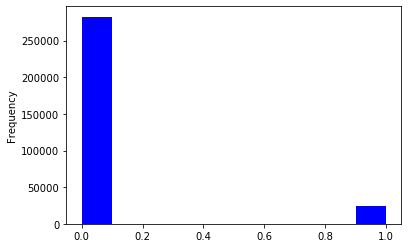

In [6]:
train.TARGET.plot.hist(color = 'b')

In [7]:
sum(train.isna().sum())/(train.shape[0]*train.shape[1])*100

24.39594190712943

In [8]:
train_NA = (np.round((train.isna().sum()/len(train)),3)).sort_values(ascending = False)*100
train_NA = train_NA.sort_values(ascending = False)
train_NA.head(10)

COMMONAREA_MEDI             69.9
COMMONAREA_AVG              69.9
COMMONAREA_MODE             69.9
NONLIVINGAPARTMENTS_MODE    69.4
NONLIVINGAPARTMENTS_MEDI    69.4
NONLIVINGAPARTMENTS_AVG     69.4
LIVINGAPARTMENTS_MEDI       68.4
LIVINGAPARTMENTS_MODE       68.4
FONDKAPREMONT_MODE          68.4
LIVINGAPARTMENTS_AVG        68.4
dtype: float64

In [9]:
# what about subcategories within categorical data
train.select_dtypes('category').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [10]:
train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

# Dealing with missing values

### 1.POS_CASH_balance

In [11]:
POS_CASH_balance.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [12]:
POS_CASH_balance_clean = POS_CASH_balance.dropna(how = 'any',axis = 0)
POS_CASH_balance_clean.isnull().sum()

SK_ID_PREV               0
SK_ID_CURR               0
MONTHS_BALANCE           0
CNT_INSTALMENT           0
CNT_INSTALMENT_FUTURE    0
NAME_CONTRACT_STATUS     0
SK_DPD                   0
SK_DPD_DEF               0
dtype: int64

### 2.Installments Payments

In [13]:
installments_payments.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [14]:
installments_payments.DAYS_ENTRY_PAYMENT[installments_payments.DAYS_ENTRY_PAYMENT.isnull()] = installments_payments.DAYS_ENTRY_PAYMENT.median()
installments_payments.AMT_PAYMENT[installments_payments.AMT_PAYMENT.isnull()] = installments_payments.AMT_PAYMENT.median()

C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 3.Credit Card Balance

In [15]:
credit_card_balance.AMT_DRAWINGS_ATM_CURRENT[credit_card_balance.AMT_DRAWINGS_ATM_CURRENT.isnull()] = credit_card_balance.AMT_DRAWINGS_ATM_CURRENT.median()
credit_card_balance.AMT_DRAWINGS_OTHER_CURRENT[credit_card_balance.AMT_DRAWINGS_OTHER_CURRENT.isnull()] = credit_card_balance.AMT_DRAWINGS_OTHER_CURRENT.median()
credit_card_balance.AMT_DRAWINGS_POS_CURRENT[credit_card_balance.AMT_DRAWINGS_POS_CURRENT.isnull()] = credit_card_balance.AMT_DRAWINGS_POS_CURRENT.median()
credit_card_balance.CNT_DRAWINGS_ATM_CURRENT[credit_card_balance.CNT_DRAWINGS_ATM_CURRENT.isnull()] = credit_card_balance.CNT_DRAWINGS_ATM_CURRENT.median()
credit_card_balance.CNT_DRAWINGS_OTHER_CURRENT[credit_card_balance.CNT_DRAWINGS_OTHER_CURRENT.isnull()] = credit_card_balance.CNT_DRAWINGS_OTHER_CURRENT.median()
credit_card_balance.CNT_DRAWINGS_POS_CURRENT[credit_card_balance.CNT_DRAWINGS_POS_CURRENT.isnull()] = credit_card_balance.CNT_DRAWINGS_POS_CURRENT.median()
credit_card_balance.AMT_INST_MIN_REGULARITY[credit_card_balance.AMT_INST_MIN_REGULARITY.isnull()] = credit_card_balance.AMT_INST_MIN_REGULARITY.median()
credit_card_balance.CNT_INSTALMENT_MATURE_CUM[credit_card_balance.CNT_INSTALMENT_MATURE_CUM.isnull()] = credit_card_balance.CNT_INSTALMENT_MATURE_CUM.median()
credit_card_balance=credit_card_balance.drop("AMT_PAYMENT_CURRENT",axis=1)

C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we c

In [16]:
credit_card_balance.isnull().sum()

SK_ID_PREV                    0
SK_ID_CURR                    0
MONTHS_BALANCE                0
AMT_BALANCE                   0
AMT_CREDIT_LIMIT_ACTUAL       0
AMT_DRAWINGS_ATM_CURRENT      0
AMT_DRAWINGS_CURRENT          0
AMT_DRAWINGS_OTHER_CURRENT    0
AMT_DRAWINGS_POS_CURRENT      0
AMT_INST_MIN_REGULARITY       0
AMT_PAYMENT_TOTAL_CURRENT     0
AMT_RECEIVABLE_PRINCIPAL      0
AMT_RECIVABLE                 0
AMT_TOTAL_RECEIVABLE          0
CNT_DRAWINGS_ATM_CURRENT      0
CNT_DRAWINGS_CURRENT          0
CNT_DRAWINGS_OTHER_CURRENT    0
CNT_DRAWINGS_POS_CURRENT      0
CNT_INSTALMENT_MATURE_CUM     0
NAME_CONTRACT_STATUS          0
SK_DPD                        0
SK_DPD_DEF                    0
dtype: int64

### 4.Bureau

In [17]:
np.sum(pd.isnull(bureau))

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [18]:
bureau.drop(["AMT_ANNUITY"],axis=1,inplace = True)
bureau.drop(["AMT_CREDIT_MAX_OVERDUE"],axis=1,inplace = True)
bureau["AMT_CREDIT_SUM_LIMIT"].fillna(bureau["AMT_CREDIT_SUM_LIMIT"].median(),inplace = True)

In [19]:
bue_debt_active=bureau.loc[bureau["CREDIT_ACTIVE"]=="Active",]
bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active") & (pd.isnull(bureau["AMT_CREDIT_SUM_DEBT"])),"AMT_CREDIT_SUM_DEBT"]=bue_debt_active["AMT_CREDIT_SUM_DEBT"].median()

In [20]:
bue_debt_badDebt=bureau.loc[bureau["CREDIT_ACTIVE"]=="Bad debt",]
bureau.loc[(bureau["CREDIT_ACTIVE"]=="Bad debt") & (pd.isnull(bureau["AMT_CREDIT_SUM_DEBT"])),"AMT_CREDIT_SUM_DEBT"]=bue_debt_active["AMT_CREDIT_SUM_DEBT"].mean()

In [21]:
bue_debt_cosed=bureau.loc[bureau["CREDIT_ACTIVE"]=="Closed",]
bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed") & (pd.isnull(bureau["AMT_CREDIT_SUM_DEBT"])),"AMT_CREDIT_SUM_DEBT"]=bue_debt_active["AMT_CREDIT_SUM_DEBT"].median()

In [22]:
bue_debt_sold=bureau.loc[bureau["CREDIT_ACTIVE"]=="Sold",]
bureau.loc[(bureau["CREDIT_ACTIVE"]=="Sold") & (pd.isnull(bureau["AMT_CREDIT_SUM_DEBT"])),"AMT_CREDIT_SUM_DEBT"]=bue_debt_active["AMT_CREDIT_SUM_DEBT"].median()

In [23]:
bureau.loc[(pd.isnull(bureau["AMT_CREDIT_SUM"])),"AMT_CREDIT_SUM"]=bue_debt_active["AMT_CREDIT_SUM"].median()

In [24]:
bureau.drop("DAYS_ENDDATE_FACT",axis=1,inplace=True)

In [25]:
bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active") & (pd.isnull(bureau["DAYS_CREDIT_ENDDATE"])),"DAYS_CREDIT_ENDDATE"]=bue_debt_active["DAYS_CREDIT_ENDDATE"].median()

bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed") & (pd.isnull(bureau["DAYS_CREDIT_ENDDATE"])),"DAYS_CREDIT_ENDDATE"]=bue_debt_active["DAYS_CREDIT_ENDDATE"].median()

bureau.loc[(bureau["CREDIT_ACTIVE"]=="Sold") & (pd.isnull(bureau["DAYS_CREDIT_ENDDATE"])),"DAYS_CREDIT_ENDDATE"]=bue_debt_active["DAYS_CREDIT_ENDDATE"].median()

bureau.loc[(bureau["CREDIT_ACTIVE"]=="Bad debt") & (pd.isnull(bureau["DAYS_CREDIT_ENDDATE"])),"DAYS_CREDIT_ENDDATE"]=bue_debt_active["DAYS_CREDIT_ENDDATE"].median()

In [26]:
np.sum(pd.isnull(bue_debt_badDebt))

SK_ID_CURR                 0
SK_ID_BUREAU               0
CREDIT_ACTIVE              0
CREDIT_CURRENCY            0
DAYS_CREDIT                0
CREDIT_DAY_OVERDUE         0
DAYS_CREDIT_ENDDATE        1
DAYS_ENDDATE_FACT         11
CNT_CREDIT_PROLONG         0
AMT_CREDIT_SUM             0
AMT_CREDIT_SUM_DEBT        6
AMT_CREDIT_SUM_LIMIT       0
AMT_CREDIT_SUM_OVERDUE     0
CREDIT_TYPE                0
DAYS_CREDIT_UPDATE         0
dtype: int64

In [27]:
np.sum(pd.isnull(bureau))

SK_ID_CURR                0
SK_ID_BUREAU              0
CREDIT_ACTIVE             0
CREDIT_CURRENCY           0
DAYS_CREDIT               0
CREDIT_DAY_OVERDUE        0
DAYS_CREDIT_ENDDATE       0
CNT_CREDIT_PROLONG        0
AMT_CREDIT_SUM            0
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_OVERDUE    0
CREDIT_TYPE               0
DAYS_CREDIT_UPDATE        0
dtype: int64

In [28]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})

### 5.Previous Application

In [29]:
previous_application.isnull().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [30]:
previous_application.AMT_ANNUITY[previous_application.AMT_ANNUITY.isnull()] = 0
previous_application.AMT_GOODS_PRICE[previous_application.AMT_GOODS_PRICE.isnull()] = 0
previous_application.DAYS_FIRST_DRAWING[previous_application.DAYS_FIRST_DRAWING.isnull()] = 0
previous_application.DAYS_FIRST_DUE[previous_application.DAYS_FIRST_DUE.isnull()] = 0
previous_application.DAYS_LAST_DUE[previous_application.DAYS_LAST_DUE.isnull()] = 0
previous_application.DAYS_LAST_DUE_1ST_VERSION[previous_application.DAYS_LAST_DUE_1ST_VERSION.isnull()] = 0
previous_application.DAYS_TERMINATION[previous_application.DAYS_TERMINATION.isnull()] = 0
previous_application.NFLAG_INSURED_ON_APPROVAL[previous_application.NFLAG_INSURED_ON_APPROVAL.isnull()] = 0
previous_application.AMT_DOWN_PAYMENT[previous_application.AMT_DOWN_PAYMENT.isnull()] = 0
previous_application.RATE_DOWN_PAYMENT[previous_application.RATE_DOWN_PAYMENT.isnull()] = 0
previous_application.CNT_PAYMENT[previous_application.CNT_PAYMENT.isnull()] = 0
previous_application.AMT_CREDIT[previous_application.AMT_CREDIT.isnull()] = 0

C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we c

In [31]:
#Dropping the variables with 99.6% missing values
previous_application.drop(['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'], axis=1, inplace=True)
previous_application.drop(['NAME_TYPE_SUITE'], axis=1, inplace=True)

In [32]:
k=previous_application["PRODUCT_COMBINATION"].mode()
previous_application.loc[pd.isnull(previous_application['PRODUCT_COMBINATION']),'PRODUCT_COMBINATION'] = k[0]

In [33]:
previous_application.isnull().sum()

SK_ID_PREV                     0
SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
AMT_ANNUITY                    0
AMT_APPLICATION                0
AMT_CREDIT                     0
AMT_DOWN_PAYMENT               0
AMT_GOODS_PRICE                0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
FLAG_LAST_APPL_PER_CONTRACT    0
NFLAG_LAST_APPL_IN_DAY         0
RATE_DOWN_PAYMENT              0
NAME_CASH_LOAN_PURPOSE         0
NAME_CONTRACT_STATUS           0
DAYS_DECISION                  0
NAME_PAYMENT_TYPE              0
CODE_REJECT_REASON             0
NAME_CLIENT_TYPE               0
NAME_GOODS_CATEGORY            0
NAME_PORTFOLIO                 0
NAME_PRODUCT_TYPE              0
CHANNEL_TYPE                   0
SELLERPLACE_AREA               0
NAME_SELLER_INDUSTRY           0
CNT_PAYMENT                    0
NAME_YIELD_GROUP               0
PRODUCT_COMBINATION            0
DAYS_FIRST_DRAWING             0
DAYS_FIRST_DUE                 0
DAYS_LAST_

### 6.Application Train

In [34]:
np.sum(pd.isnull(train))

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [35]:
train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(),inplace=True)

train["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(),inplace=True)

train["NAME_TYPE_SUITE"].fillna(train["NAME_TYPE_SUITE"].mode()[0],inplace=True)

train.loc[(train["FLAG_OWN_CAR"]=='Y') & (pd.isnull(train["OWN_CAR_AGE"])),"OWN_CAR_AGE" ]=train["OWN_CAR_AGE"].median()

train.loc[(train["FLAG_OWN_CAR"]=='N') & (pd.isnull(train["OWN_CAR_AGE"])),"OWN_CAR_AGE" ]=0.0


all_cols=train.columns
num_cols=train._get_numeric_data().columns
categoriacal_cols=list(set(all_cols)-set(num_cols))
categoriacal_cols



nulls = train.isnull().sum()
percent_nulls = (nulls/train.isnull().count())*100
missing_values  = pd.concat([nulls, percent_nulls], axis=1, keys=['Total', 'Percent'])
missing_values
# Vignesh


#Imputing the AMT_REQ columns with median
amt_req = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']
for i in amt_req:
    train.loc[pd.isnull(train[i]),i] = train[i].median()


#Imputing the OBS_DEF columns with median
obs_def = ['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
for i in obs_def:
    train.loc[pd.isnull(train[i]),i] = train[i].median()



train.loc[pd.isnull(train['DAYS_LAST_PHONE_CHANGE']),'DAYS_LAST_PHONE_CHANGE'] = train['DAYS_LAST_PHONE_CHANGE'].median()

train.loc[pd.isnull(train['EXT_SOURCE_2']),'EXT_SOURCE_2'] = train['EXT_SOURCE_2'].median()
train.loc[pd.isnull(train['EXT_SOURCE_3']),'EXT_SOURCE_3'] = train['EXT_SOURCE_3'].median()
train.loc[pd.isnull(train['CNT_FAM_MEMBERS']),'CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].median()

In [36]:
lst = train.columns
housing_columns = lst[44:91]


for i in range(len(housing_columns)):
    train[housing_columns[i]].fillna(0,inplace=True)



train.drop(["WALLSMATERIAL_MODE"],axis=1,inplace = True)

train.drop(["HOUSETYPE_MODE"],axis=1,inplace = True)

train.drop(["FONDKAPREMONT_MODE"],axis=1,inplace = True)
train.drop(["EXT_SOURCE_1"],axis=1,inplace = True)
# Need to re consider this columns


train.drop(["OCCUPATION_TYPE"],axis=1,inplace = True)
train.drop(["EMERGENCYSTATE_MODE"],axis=1,inplace = True)

In [37]:
train=reduce_mem_usage(train)

Memory usage of dataframe is 272.15 MB
Memory usage after optimization is: 57.49 MB
Decreased by 78.9%


### 7.Application Test

In [38]:
test["AMT_ANNUITY"].fillna(test["AMT_ANNUITY"].median(),inplace=True)

test["AMT_GOODS_PRICE"].fillna(test["AMT_GOODS_PRICE"].median(),inplace=True)

test["NAME_TYPE_SUITE"].fillna(test["NAME_TYPE_SUITE"].mode()[0],inplace=True)

test.loc[(test["FLAG_OWN_CAR"]=='Y') & (pd.isnull(test["OWN_CAR_AGE"])),"OWN_CAR_AGE" ]=test["OWN_CAR_AGE"].median()

test.loc[(test["FLAG_OWN_CAR"]=='N') & (pd.isnull(test["OWN_CAR_AGE"])),"OWN_CAR_AGE" ]=0.0


all_cols=test.columns
num_cols=test._get_numeric_data().columns
categoriacal_cols=list(set(all_cols)-set(num_cols))
categoriacal_cols



nulls = test.isnull().sum()
percent_nulls = (nulls/test.isnull().count())*100
missing_values  = pd.concat([nulls, percent_nulls], axis=1, keys=['Total', 'Percent'])
missing_values



#Imputing the AMT_REQ columns with median
amt_req = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']
for i in amt_req:
    test.loc[pd.isnull(test[i]),i] = test[i].median()


#Imputing the OBS_DEF columns with median
obs_def = ['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
for i in obs_def:
    test.loc[pd.isnull(test[i]),i] = test[i].median()



test.loc[pd.isnull(test['DAYS_LAST_PHONE_CHANGE']),'DAYS_LAST_PHONE_CHANGE'] = test['DAYS_LAST_PHONE_CHANGE'].median()

test.loc[pd.isnull(test['EXT_SOURCE_2']),'EXT_SOURCE_2'] = test['EXT_SOURCE_2'].median()
test.loc[pd.isnull(test['EXT_SOURCE_3']),'EXT_SOURCE_3'] = test['EXT_SOURCE_3'].median()
test.loc[pd.isnull(test['CNT_FAM_MEMBERS']),'CNT_FAM_MEMBERS'] = test['CNT_FAM_MEMBERS'].median()

In [39]:
lst = test.columns
housing_columns = lst[44:91]


for i in range(len(housing_columns)):
    test[housing_columns[i]].fillna(0,inplace=True)



test.drop(["WALLSMATERIAL_MODE"],axis=1,inplace = True)

test.drop(["HOUSETYPE_MODE"],axis=1,inplace = True)

test.drop(["FONDKAPREMONT_MODE"],axis=1,inplace = True)
test.drop(["EXT_SOURCE_1"],axis=1,inplace = True)
# Need to re consider this columns


test.drop(["OCCUPATION_TYPE"],axis=1,inplace = True)
test.drop(["EMERGENCYSTATE_MODE"],axis=1,inplace = True)

In [40]:
test=reduce_mem_usage(test)

Memory usage of dataframe is 42.77 MB
Memory usage after optimization is: 9.07 MB
Decreased by 78.8%


### Data Prepration

### Joining all the files 

In [41]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [42]:
train.shape

(307511, 210)

In [43]:
test.shape

(48744, 207)

In [44]:
train_labels = train['TARGET']

In [45]:
train, test = train.align(test, join = 'inner', axis = 1)

#### Merging train and test datasets

In [46]:
data = train.append(test)

In [47]:
data = data.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

In [48]:
# first define the formula for grouping rows by ID and calculating mean values
def extract_mean(x):
    y = x.groupby('SK_ID_BUREAU', as_index=False).mean().add_prefix('BUR_BAL_MEAN_') 
    return y

#### Merging Bureau balance to the above merge

In [49]:
bureau_bal_mean = extract_mean(bureau_balance)

In [50]:
bureau_bal_mean = bureau_bal_mean.rename(columns = {'BUR_BAL_MEAN_SK_ID_BUREAU' : 'SK_ID_BUREAU'})

In [51]:
bureau = bureau.merge(bureau_bal_mean, on = 'SK_ID_BUREAU', how = 'left')
bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)

In [52]:
def extract_mean(x):
    y = x.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_') # note that we have changed the ID to group by and the prefix to add
    return y

In [53]:
bureau_mean_values = extract_mean(bureau)
bureau_mean_values = bureau_mean_values.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})

In [54]:
data = data.merge(bureau_mean_values, on = 'SK_ID_CURR', how = 'left')

In [55]:
data.shape

(356255, 218)

In [56]:
credit_card_balance.drop('SK_ID_CURR', axis = 1, inplace = True)
installments_payments.drop('SK_ID_CURR', axis = 1, inplace = True)
POS_CASH_balance.drop('SK_ID_CURR', axis = 1, inplace = True)

In [57]:
previous_application_counts = previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


#### Merging Previous application to the above merge

In [58]:
data = data.merge(previous_application_counts, on = 'SK_ID_CURR', how = 'left')

In [59]:
data.head(5)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_BUR_BAL_MEAN_MONTHS_BALANCE,PREVIOUS_APPLICATION_COUNT
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,...,0.0,-92.25,0.0,108131.945312,67203.0,3998.570557,0.0,-499.875,-21.875,1.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,...,0.0,-544.50,0.0,254350.125000,0.0,202500.000000,0.0,-816.000,NaN,3.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010033,-19046,-225,-4260.0,...,0.0,-488.50,0.0,94518.898438,0.0,0.000000,0.0,-532.000,NaN,1.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008018,-19005,-3039,-9832.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028656,-19932,-3038,-4312.0,...,0.0,-783.00,0.0,146250.000000,0.0,0.000000,0.0,-783.000,NaN,6.0


In [60]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
    return y

credit_card_balance_mean = extract_mean(credit_card_balance)

credit_card_balance_mean = credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

In [61]:
previous_application = previous_application.merge(credit_card_balance_mean, on = 'SK_ID_PREV', how = 'left')

In [62]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
    return y

install_pay_mean = extract_mean(installments_payments)

install_pay_mean = install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

In [63]:
previous_application = previous_application.merge(install_pay_mean, on = 'SK_ID_PREV', how = 'left')

In [64]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
    return y

POS_mean = extract_mean(POS_CASH_balance)

POS_mean = POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

In [65]:
previous_application = previous_application.merge(POS_mean, on = 'SK_ID_PREV', how = 'left')

In [66]:
def extract_mean(x):
    y = x.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
    return y

prev_appl_mean = extract_mean(previous_application)

prev_appl_mean = prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})

prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis = 1) 

In [67]:
data.shape

(356255, 219)

In [68]:
data = data.merge(prev_appl_mean, on = 'SK_ID_CURR', how = 'left')

#### Now we seperate test and train to fit and predict the model

In [69]:
train1 = data[data['SK_ID_CURR'].isin(train.SK_ID_CURR)]

test1 = data[data.SK_ID_CURR.isin(test.SK_ID_CURR)]

In [70]:
train1.isnull().sum()

SK_ID_CURR                                           0
CNT_CHILDREN                                         0
AMT_INCOME_TOTAL                                     0
AMT_CREDIT                                           0
AMT_ANNUITY                                          0
                                                 ...  
PREV_APPL_MEAN_POS_MEAN_MONTHS_BALANCE           20544
PREV_APPL_MEAN_POS_MEAN_CNT_INSTALMENT           20576
PREV_APPL_MEAN_POS_MEAN_CNT_INSTALMENT_FUTURE    20576
PREV_APPL_MEAN_POS_MEAN_SK_DPD                   20544
PREV_APPL_MEAN_POS_MEAN_SK_DPD_DEF               20544
Length: 266, dtype: int64

In [71]:
test1.shape

(48744, 266)

In [76]:
train1[train1.isnull()]=0
test1[test1.isnull()]=0

C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\91808\Anaconda3\lib\site-packages\pandas\core\frame.py:3530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
C:\Users\91808\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

### Splitting Train data into train  and test

In [77]:
y = train_labels
x=train1
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x,y, stratify = y,
                                                      test_size =0.25)

## Model 1 

### Fitting a logistic model with L1 regularisation

In [107]:
GLM = LogisticRegression(C = 0.01,class_weight='balanced',penalty='l1',solver='liblinear')

# Fit the model to the training data
GLM.fit(x_train, y_train)

# Predict on the testing data
GLM_pred = GLM.predict_proba(x_test)[:, 1] # use predict_proba to predict probabilities and 
                                            # [:,1] for the 1 probability output (by default it will save both probabilities, 
                                                # for value 0 and value 1)

C:\Users\91808\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Predicting the model accuracy

In [108]:
logistic_acc = accuracy_score(y_test,GLM_pred.round())
print('Logistic accuracy',logistic_acc)

Logistic accuracy 0.6976638310049689


#### Creating Confusion matrix

In [109]:
logistic_conf = confusion_matrix(y_test,GLM_pred.round())
logistic_conf

array([[49419, 21253],
       [ 1990,  4216]], dtype=int64)

In [81]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score

In [110]:
auc = roc_auc_score(y_test,GLM_pred)
print ("The AUROC score is:",auc)

The AUROC score is: 0.751680934982184


### Weight of Evidence

In [111]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 2

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [112]:
final_iv, IV = data_vars(x_train, y_train)

C:\Users\91808\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### The list of important variables are

In [113]:
IV.sort_values('IV',ascending='F').tail(50)

,VAR_NAME,IV
78,LIVE_CITY_NOT_WORK_CITY,0.012953
220,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,0.013585
55,FLAG_DOCUMENT_6,0.013740
231,PREV_APPL_MEAN_POS_MEAN_SK_DPD_DEF,0.014576
229,PREV_APPL_MEAN_POS_MEAN_MONTHS_BALANCE,0.014649
87,NAME_CONTRACT_TYPE_Revolving loans,0.015710
86,NAME_CONTRACT_TYPE_Cash loans,0.015710
187,PREV_APPL_MEAN_AMT_ANNUITY,0.016844
207,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE...,0.019007
232,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,0.019765


In [114]:
variables=IV.sort_values('IV',ascending='F').tail(50)

In [115]:
 lt_V15=list(variables['VAR_NAME'])

## Model 2

### Logistic Model with top 50 variables

In [116]:
x_train_15 = x_train[lt_V15]

In [117]:
x_test_15=x_test[lt_V15]

In [118]:
GLM = LogisticRegression(C = 0.01,class_weight='balanced',penalty='l1',solver='liblinear')

# Fit the model to the training data
GLM.fit(x_train_15, y_train)

# Predict on the testing data
GLM_pred = GLM.predict_proba(x_test_15)[:, 1]

C:\Users\91808\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [119]:
pre=GLM.predict_proba(x_test_15)[:, 1]

In [120]:
datfr=pd.DataFrame(y_test)
datfr['Pred']=pre
datfr.to_csv("conco.csv") # Concordance is been done on R

#### The accuracy of the model

In [121]:
logistic_acc = accuracy_score(y_test,GLM_pred.round())
print('Logistic accuracy',logistic_acc)

Logistic accuracy 0.6859829860298134


#### The AUROC value

In [122]:
auc = roc_auc_score(y_test,GLM_pred)
print("The AUROC value for the model is:",auc)

The AUROC value for the model is: 0.7363260674140744


### Creating AUROC curve for the model

In [98]:
from sklearn import metrics

In [99]:
def draw_roc(actual,probs):
    fpr,tpr,thresholds = metrics.roc_curve(actual,probs,drop_intermediate=False)
    
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' %auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc = "lower right")
    plt.show()
    
    return fpr, tpr, thresholds

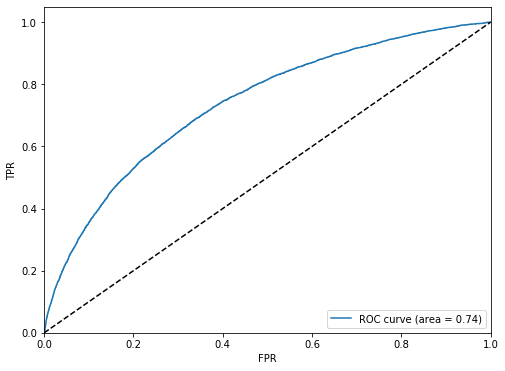

(array([0.00000000e+00, 1.41498755e-05, 2.82997510e-05, ...,
        9.99971700e-01, 9.99985850e-01, 1.00000000e+00]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([2.        , 1.        , 0.99996222, ..., 0.0235246 , 0.01628479,
        0.00348448]))

In [123]:
draw_roc(y_test, pre)

In [124]:
GLM_pred

array([0.61391028, 0.25932971, 0.42081965, ..., 0.3904478 , 0.49796301,
       0.66432509])

In [125]:
df=pd.DataFrame(GLM_pred)
df.columns=["Pred"]
df

,Pred
0,0.613910
1,0.259330
2,0.420820
3,0.431841
4,0.604668
...,...
76873,0.302705
76874,0.291920
76875,0.390448
76876,0.497963


In [126]:
df['predicted'] = df.Pred.map(lambda x:1 if x>0.55 else 0)

,Pred,predicted
0,0.613910,1
1,0.259330,0
2,0.420820,0
3,0.431841,0
4,0.604668,1
...,...,...
76873,0.302705,0
76874,0.291920,0
76875,0.390448,0
76876,0.497963,0


In [136]:
df['TARGET']=y_test

### The F-1 score of the model

In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_test, df.predicted))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     70672
           1       0.18      0.58      0.27      6206

    accuracy                           0.75     76878
   macro avg       0.56      0.67      0.56     76878
weighted avg       0.89      0.75      0.80     76878



In [128]:
logistic_conf = confusion_matrix(y_test,df.predicted, [0,1])
logistic_conf

array([[53816, 16856],
       [ 2625,  3581]], dtype=int64)

In [129]:
test_s=test1[lt_V15]

In [130]:
GLM_pred_test = GLM.predict_proba(test_s)[:, 1]

In [131]:
GLM_pred_test

array([0.40875325, 0.73282457, 0.2037797 , ..., 0.51294862, 0.3603281 ,
       0.71583837])

In [132]:
d=test1['SK_ID_CURR']
d =pd.DataFrame(d)

In [133]:
d['TARGET']=GLM_pred_test

In [134]:
d.to_csv('sample_submission.csv')

In [ ]:
os.getcwd()

In [140]:
conc =pd.DataFrame(y_test)

In [142]:
conc["Pred"]=GLM_pred

In [144]:
conc.to_csv('conc.csv')